In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# Подготовка данных

Загрузка данных

In [2]:
xlsx_file = pd.ExcelFile('input/БОГРАД_PISY.xlsx')
trees = ['pisy_01a', 'pisy_01b', 'pisy_02a', 'pisy_03a', 'pisy_07a', 'pisy_12b', 'pisy_14a']
columns = {_:f'D{__}' if __<16 else f'CWT{__-15}' for _, __ in zip(range(2,32), range(1,31))}
columns[0] = 'Tree'
columns[1] = 'Year'

Функция нормализации трахеид

In [3]:
def get_normalized_list(x: list, norm : int):
    """
    Функция получения нормированного списка
    :param x: список для нормирования
    :param norm: норма
    :return: l_norm - нормированный к e список l
    """
    l_raw = []  # промежуточный список
    n = len(x)
    for i in range(n):
        for j in range(norm):
            l_raw += [x[i]]
    l_norm = []
    for i in range(norm):
        l_norm += [1 / n * sum([l_raw[j] for j in range(n * i, n * (i + 1))])]
    return l_norm

Нормализуем входные данные

In [4]:
dataframes = []
for tree in trees:
    df = xlsx_file.parse(tree)
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    df = df.dropna(axis=0)

    norm_traches = dict()
    for year in set(df['Год']):
        norm_traches[int(year)] = [tree, int(year)] + get_normalized_list(list(df[df['Год']==year]['Dmean']), 15)+ get_normalized_list(list(df[df['Год']==year]['CWTmean']), 15)
    
    dataframes += [pd.DataFrame(norm_traches).transpose().rename(columns=columns).reset_index(drop=True)]

df = pd.concat(dataframes).reset_index(drop=True)

Сохраняем их в .xlsx файл

In [6]:
df.to_excel('output/Bograd_PISY_normalized.xlsx', index=False)

Рассчёт средних значений трахеид по годам и по деревьям:

In [5]:
mean_objects_years = dict()

for year in set(df['Year']):
    temp_data = df[df['Year']==year]
    if len(temp_data) > 3:
        mean_objects_years[year] = temp_data.mean()[1:]


mean_objects_trees = dict()

for tree in set(df['Tree']):
    mean_objects_trees[tree] = df[df['Tree']==tree].mean()[1:]

Считаем средние значения трахеид по всем записям

In [6]:
global_mean = df.mean()[1:]

Строим таблицы объектов для метода A -- кластеризация отклонений средних объектов по году от среднего глобального объекта:

In [7]:
quotient_deviation_df_A = []

_columns = {_:f'D{_}' if _<16 else f'CWT{_-15}' for _ in  range(1,31)}
_columns[0] = 'Year'

for year, mean_obj in mean_objects_years.items():
    quotient_deviation_df_A += [[year] + list(mean_obj/global_mean)]

quotient_deviation_df_A = pd.DataFrame(quotient_deviation_df_A).rename(columns=_columns)

In [10]:
quotient_deviation_df_A.to_excel('output/quotient_deviation_df_A.xlsx', index=False)

Строим таблицы объектов для метода B -- кластеризация средних отклонений объектов по году от среднего объекта по дереву:

In [8]:
qd_df_B = []

quotient_deviation_df_B = dict()


for _, row in df.iterrows():
    qd_df_B += [[row[0], row[1]] + list(row[2:] / mean_objects_trees[row[0]])]

qd_df_B = pd.DataFrame(qd_df_B).rename(columns=columns)

for year in set(df['Year']):
    temp_data_q = qd_df_B[qd_df_B['Year']==year]
    if len(temp_data_q) > 3:
        quotient_deviation_df_B[year] = temp_data_q.mean()[1:]

quotient_deviation_df_B = pd.DataFrame(quotient_deviation_df_B).transpose()

In [12]:
quotient_deviation_df_B.to_excel('output/quotient_deviation_df_B.xlsx', index=True)

# Кластеризация

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


def get_models(data, name='Data'):
    models = []
    inertia = []
    silhouette = []
    print(name, end=': ')
    for n_clusters in range(2, 16):
        print(n_clusters, end=', ')
        # Описываем модель
        model = KMeans(n_clusters=n_clusters, max_iter=5000, random_state=0)

        # Проводим моделирование
        model.fit(data)

        # Предсказание на всем наборе данных
        all_predictions = model.predict(data)

        # Распихиваем точки по кластерам
        clusters = [[] for i in range(n_clusters)]
        for i, num in enumerate(all_predictions):
            clusters[num] += [data[i]]
        
        models += [model]
        inertia += [model.inertia_]
        silhouette += [silhouette_score(data, model.labels_, metric='euclidean')]
    print('done!')
    return models, inertia, silhouette

Тут формируем массивы обучабщих выборок для обоих методов:

In [138]:
quo_data_A  = np.array(quotient_deviation_df_A.drop(['Year'], axis=1))
quo_data_B  = np.array(quotient_deviation_df_B)

Обучаем модели для каждого метода:

In [11]:
models_quo_A, i_1, s_1 = get_models(quo_data_A, 'A quo')
models_quo_B, i_1, s_1 = get_models(quo_data_B, 'B quo')

A quo: 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, done!
B quo: 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, done!


Функция сохранения графиков кластеров и их средних объектов:

In [147]:
def save_clusters(models, data, amount=15, num=3, data_type='below', ylim=None):
    all_predictions = models[num-2].predict(data)
    try:
        os.mkdir(f'output/{data_type}/')
    except Exception as e:
        pass
    try:
        os.mkdir(f'output/{data_type}/{num}_clust/')
    except Exception as e:
        pass
    for j in range(num):
        fig, ax = plt.subplots( nrows=1, ncols=1)
        ax.plot(range(1,amount+1), models[num-2].cluster_centers_[j])
        ax.set_title(f'Mean object (cluster №{j+1})')
        if ylim:
            ax.set_ylim(ylim)
        fig.savefig(f'output/{data_type}/{num}_clust/mean_obj_cluster_{j+1}.png')
        plt.close(fig)
        
        fig, ax = plt.subplots( nrows=1, ncols=1)
        els = 0
        for i in range(len(all_predictions)):
            if all_predictions[i] == j:
                ax.plot(range(1,amount+1), data[i], label=str(i))
                els += 1
        #legend(frameon=False)
        if ylim:
            ax.set_ylim(ylim)
        ax.set_title(f'Cluster №{j+1} ({els} elements)')
        fig.savefig(f'output/{data_type}/{num}_clust/cluster_{j+1}.png') 
        plt.close(fig)

In [107]:
def final_save_clusters(models, data, amount=15, num=3, data_type='below', ylim=None):
    all_predictions = models[num-2].predict(data)
    try:
        os.mkdir(f'output/final_{data_type}/')
    except Exception as e:
        pass
    try:
        os.mkdir(f'output/final_{data_type}/{num}_clust/')
    except Exception as e:
        pass
    for j in range(num):

        fig, ax = plt.subplots( nrows=1, ncols=1, dpi=300)

        els = 0
        for i in range(len(all_predictions)):
            if all_predictions[i] == j:
                ax.plot(range(1,amount+1), data[i], label=str(i), color='lightgray')
                els += 1

        ax.axhline(y=1, color='dimgray', linestyle='--')
        ax.axvline(x=15, color='dimgray', linestyle='dotted')

        
        ax.plot(range(1,amount+1), models[num-2].cluster_centers_[j], color='black')

        ax.text(0.15, 0.90, 'Diam',
                verticalalignment='bottom', horizontalalignment='right',
                transform=ax.transAxes, fontsize=15)
        ax.text(0.6, 0.90, 'CWT',
                verticalalignment='bottom', horizontalalignment='right',
                transform=ax.transAxes, fontsize=15)
        
        if ylim:
            ax.set_ylim(ylim)
        ax.set_title(f'Cluster №{j+1} ({els} elements)')
        #plt.show()
        fig.savefig(f'output/final_{data_type}/{num}_clust/cluster_{j+1}.png', dpi=300) 
        plt.close(fig)

Сохраняем графики для всех моделей:

In [17]:
for _ in range(3, 6):
    save_clusters(models_quo_A, quo_data_A, 30, _, 'A_Quotient', [0.5, 1.5])
    save_clusters(models_quo_B, quo_data_B, 30, _, 'B_Quotient', [0.5, 1.5])

In [108]:
for _ in range(4, 5):
    final_save_clusters(models_quo_A, quo_data_A, 30, _, 'A_Quotient', [0.7, 1.3])
    #final_save_clusters(models_quo_B, quo_data_B, 30, _, 'B_Quotient', [0.7, 1.3])

Сохраняем таблицы кластеризованных объектов:

In [18]:
for i in range(2, 16):
    quotient_deviation_df_A[f'Class {i}'] = models_quo_A[i-2].predict(quo_data_A)
    #difference_deviation_df_A[f'Class {i}'] = models_diff_A[i-2].predict(diff_data_A)
    quotient_deviation_df_B[f'Class {i}'] = models_quo_B[i-2].predict(quo_data_B)
    #difference_deviation_df_B[f'Class {i}'] = models_diff_B[i-3].predict(diff_data_B)

quotient_deviation_df_A.to_excel('output/quotient_deviation_df_A_CLASSIFIED.xlsx', index=False)
#difference_deviation_df_A.to_excel('output/difference_deviation_df_A_CLASSIFIED.xlsx', index=False)
quotient_deviation_df_B.to_excel('output/quotient_deviation_df_B_CLASSIFIED.xlsx', index=True)
#difference_deviation_df_B.to_excel('output/difference_deviation_df_B_CLASSIFIED.xlsx', index=True)

# Сравнение методов:

Строим таблицу коэффициентов корреляции Спирмена для двух методов:

In [215]:
quotient_deviation_df_A = pd.read_excel('output/quotient_deviation_df_A_CLASSIFIED.xlsx')
quotient_deviation_df_B = pd.read_excel('output/quotient_deviation_df_B_CLASSIFIED_FIXED.xlsx')

In [216]:
QCorr = quotient_deviation_df_A.drop(['Year'], axis=1).corrwith(
        quotient_deviation_df_B.drop(['Year'], axis=1).reset_index(drop=True),
        method='spearman')

In [221]:
corrs = []
p_values = []
for column in quotient_deviation_df_A.columns:
    _c, _p = spearmanr(quotient_deviation_df_A[column], quotient_deviation_df_B[column])
    corrs += [_c]
    p_values += [_p]

spearman_corr_df = pd.DataFrame({'Feature':quotient_deviation_df_A.columns, 'Spearman': corrs, 'P-value': p_values})
spearman_corr_df.to_excel('output/spearman_correlation_new.xlsx')

Строим сравнительные графики для двух методов и двух типов отклонений:

In [21]:
d_names = [
    ['D1', 'D2', 'D3'],
    ['D4', 'D5', 'D6'],
    ['D7', 'D8', 'D9'],
    ['D10', 'D11', 'D12'],
    ['D13', 'D14', 'D15']
]

cwt_names = [
    ['CWT1', 'CWT2', 'CWT3'],
    ['CWT4', 'CWT5', 'CWT6'],
    ['CWT7', 'CWT8', 'CWT9'],
    ['CWT10', 'CWT11', 'CWT12'],
    ['CWT13', 'CWT14', 'CWT15']
]

def save_corr_plots(df1, df2, names, corr_row, output_name=''):
    fig, ax = plt.subplots(5,3, figsize=(15,12), dpi=300)
    for i, row in enumerate(names):
        for j, el in enumerate(row):
            ax[i, j].scatter(df1[el], df2[el])
            ax[i, j].text(0.1, 0.8, f"{el},  r={corr_row[el]:0.4f}", transform=ax[i, j].transAxes)
    fig.savefig(f'output/{output_name}.png', dpi=300) 
    plt.close(fig)

save_corr_plots(quotient_deviation_df_A, quotient_deviation_df_B, d_names, spearman_corr_df['Quotient'], 'Quotient_D_corr')
save_corr_plots(quotient_deviation_df_A, quotient_deviation_df_B, cwt_names, spearman_corr_df['Quotient'], 'Quotient_CWT_corr')

# Шкалирование

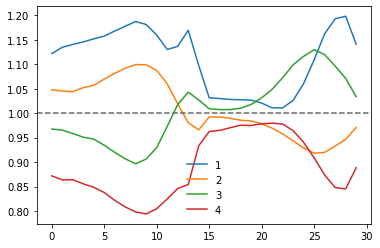

In [37]:
for i in range(4):
    plt.plot(models_quo_A[2].cluster_centers_[i],label=str(i+1))
plt.axhline(y=1, color='dimgray', linestyle='--')
plt.legend(frameon=False)

In [61]:
from scipy.integrate import simps
from numpy import trapz

for i in range(4):
    pos = trapz([el for el in models_quo_A[2].cluster_centers_[i][:15] if el >= 1])
    neg = trapz([el for el in models_quo_A[2].cluster_centers_[i][:15] if el < 1])
    print('Diam', i+1, ':', pos - neg)
for i in range(4):
    pos = trapz([el for el in models_quo_A[2].cluster_centers_[i][15:] if el >= 1])
    neg = trapz([el for el in models_quo_A[2].cluster_centers_[i][15:] if el < 1])
    print('CWT', i+1, ':', pos - neg)

Diam 1 : 16.147704995346952
Diam 2 : 11.846233096008525
Diam 3 : -8.220909367821411
Diam 4 : -11.72601158144886
CWT 1 : 14.988937491111374
CWT 2 : -13.427999589801171
CWT 3 : 14.848086172399565
CWT 4 : -13.127053279195788


In [2]:
quotient_deviation_df_A = pd.read_excel('input\quotient_deviation_df_A_CLASSIFIED.xlsx')
quotient_deviation_df_B = pd.read_excel('input\quotient_deviation_df_B_CLASSIFIED.xlsx')

In [223]:
crn = pd.read_excel('input/BGD_chron.xlsx')
crn = crn[crn['Year']>1812]

In [227]:
diam_scale = {
    1:4,
    2:3,
    3:2,
    4:1
}

cwt_scale = {
    1:4,
    2:1,
    3:3,
    4:2
}

In [226]:
import numpy as np
from scipy.stats import pearsonr
from scipy.interpolate import interp1d

def dropna_pearsonr(x, y):
    x, y = np.array(x), np.array(y)
    nas = np.logical_or(np.isnan(x), np.isnan(y))
    x, y = x[~nas], y[~nas]
    r, p = pearsonr(x, y)
    return r, p

In [228]:
y1 = [diam_scale[i+1] for i in quotient_deviation_df_A['Class 4']]
y2 = [cwt_scale[i+1] for i in quotient_deviation_df_A['Class 4']]
y3 = [cwt_scale[i+1] + diam_scale[i+1] for i in quotient_deviation_df_A['Class 4']]

In [229]:
res = crn[crn['Year'].isin(quotient_deviation_df_A['Year'])]['res']
r, p = dropna_pearsonr(res, y1)
print(f'res / Diam;{r};{p}')
r, p = dropna_pearsonr(res, y2)
print(f'res / CWT;{r};{p}')
r, p = dropna_pearsonr(res, y3)
print(f'res / Diam+CWT;{r};{p}')

std = crn[crn['Year'].isin(quotient_deviation_df_A['Year'])]['std']
r, p = dropna_pearsonr(std, y1)
print(f'std / Diam;{r};{p}')
r, p = dropna_pearsonr(std, y2)
print(f'std / CWT;{r};{p}')
r, p = dropna_pearsonr(std, y3)
print(f'std / Diam+CWT;{r};{p}')

res / Diam;0.5232885477802087;1.3501744060669898e-15
res / CWT;0.3112202186020918;6.535282384041057e-06
res / Diam+CWT;0.5232916132494607;1.3495703842132766e-15
std / Diam;0.4950604212708617;6.91274013914695e-14
std / CWT;0.36003644217910963;1.418104460779469e-07
std / Diam+CWT;0.5371012377976795;1.716025095814243e-16


In [231]:
fig, axes = plt.subplots( nrows=5, ncols=1, dpi=300, figsize=(10,6))
plt.subplots_adjust(hspace=0)
axes[0].plot(crn['Year'], crn['res'], c='black', label='res')
axes[1].plot(crn['Year'], crn['std'], c='black', label='std')
#axes[0].legend(frameon=False)


x = quotient_deviation_df_A['Year']
axes[2].bar(x, y1, color='dimgray')
axes[3].bar(x, y2, color='dimgray')
axes[4].bar(x, y3, color='dimgray')

x1 = np.arange(min(x), max(x), 0.2)
axes[2].plot(x1, interp1d(x, y1, kind='cubic')(x1), color='black')
axes[3].plot(x1, interp1d(x, y2, kind='cubic')(x1), color='black')
axes[4].plot(x1, interp1d(x, y3, kind='cubic')(x1), color='black')


axes[0].set_ylim([0, 2])
axes[1].set_ylim([0, 2])
axes[2].set_ylim([0,4.5])
axes[3].set_ylim([0,4.5])
axes[4].set_ylim([0,9])

axes[0].set_ylabel('res')
axes[1].set_ylabel('std')
axes[2].set_ylabel('Diam')
axes[3].set_ylabel('CWT')
axes[4].set_ylabel('Diam + CWT')

axes[0].set_yticks(np.arange(0.5,2, 0.5))
axes[1].set_yticks(np.arange(0.5,2, 0.5))
axes[2].set_yticks(range(1,5))
axes[3].set_yticks(range(1,5))
axes[4].set_yticks(range(0,9,2))

fig.savefig(f'output/scale_res.png', dpi=300) 
plt.close(fig)

# График того, как строились классифицируемые объекты

In [130]:
fig = plt.figure(constrained_layout=True, figsize=(8,8), dpi=200)
#plt.subplots_adjust(right=0.95, hspace=0.05, wspace=0.05, bottom=0.01)
gs = fig.add_gridspec(8, 9)
axes = [
    fig.add_subplot(gs[0:2, 0:3]),
    fig.add_subplot(gs[2:4, 0:3]),
    fig.add_subplot(gs[4:6, 0:3]),
    fig.add_subplot(gs[6:8, 0:3]),
    fig.add_subplot(gs[3:5, 4:10])
]

axes[0].plot(range(1,16), df.iloc[200][2:17], 'gray')
axes[0].plot(range(1,16), global_mean[:15], color='black',linestyle='--' )
axes[1].plot(range(1,16), [i / j for i, j in zip(df.iloc[200][2:17], global_mean[:15])], 'dimgray')
axes[1].axhline(y=1, color='dimgray', linestyle='--')
axes[2].plot(range(1,16), df.iloc[200][17:], 'gray')
axes[2].plot(range(1,16), global_mean[15:], color='black',linestyle='--' )
axes[3].plot(range(1,16), [i / j for i, j in zip(df.iloc[200][17:], global_mean[15:])], 'dimgray')
axes[3].axhline(y=1, color='dimgray', linestyle='--')

axes[4].plot(range(1,31), [i / j for i, j in zip(df.iloc[200][2:], list(global_mean))], 'dimgray')
axes[4].axhline(y=1, color='dimgray', linestyle='--')
axes[4].axvline(x=15, color='dimgray', linestyle='--')

axes[1].set_ylim([0.7, 1.3])
axes[3].set_ylim([0.7, 1.3])
axes[4].set_ylim([0.7, 1.3])

fig.savefig(f'output/demo_method_A.png', dpi=300) 
plt.close(fig)

In [145]:
quo_data_A_D  = np.array(quotient_deviation_df_A.drop(['Year'] + [f'Class {i}' for i in range(2, 16)] + [f'CWT{i}' for i in range(1, 16)], axis=1))
quo_data_A_CWT  = np.array(quotient_deviation_df_A.drop(['Year'] + [f'Class {i}' for i in range(2, 16)] + [f'D{i}' for i in range(1, 16)], axis=1))
quo_data_B_D  = np.array(quotient_deviation_df_B.drop(['Unnamed: 0'] + [f'Class {i}' for i in range(2, 16)] + [f'CWT{i}' for i in range(1, 16)], axis=1))
quo_data_B_CWT  = np.array(quotient_deviation_df_B.drop(['Unnamed: 0'] + [f'Class {i}' for i in range(2, 16)] + [f'D{i}' for i in range(1, 16)], axis=1))


In [156]:
pd.DataFrame(quo_data_A_D).to_csv('A_Diam.csv', index=False)
pd.DataFrame(quo_data_A_CWT).to_csv('A_CWT.csv', index=False)
pd.DataFrame(quo_data_B_D).to_csv('B_Diam.csv', index=False)
pd.DataFrame(quo_data_B_CWT).to_csv('B_CWT.csv', index=False)

In [146]:
models_quo_A_D, i_1, s_1 = get_models(quo_data_A_D, 'A D')
models_quo_A_CWT, i_1, s_1 = get_models(quo_data_A_CWT, 'A CWT')
models_quo_B_D, i_1, s_1 = get_models(quo_data_B_D, 'B D')
models_quo_B_CWT, i_1, s_1 = get_models(quo_data_B_CWT, 'B CWT')

A D: 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, done!
A CWT: 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, done!
B D: 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, done!
B CWT: 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, done!


In [152]:
for i in range(2, 6):
    save_clusters(models_quo_A_D, quo_data_A_D, amount=15, num=i, data_type='Quotient_A_Diam', ylim=[0.5, 1.5])
    save_clusters(models_quo_A_CWT, quo_data_A_CWT, amount=15, num=i, data_type='Quotient_A_CWT', ylim=[0.5, 1.5])
    save_clusters(models_quo_B_D, quo_data_B_D, amount=15, num=i, data_type='Quotient_B_Diam', ylim=[0.5, 1.5])
    save_clusters(models_quo_B_CWT, quo_data_B_CWT, amount=15, num=i, data_type='Quotient_B_CWT', ylim=[0.5, 1.5])

# Сравнение с климатикой

In [2]:
min_temp = pd.read_excel('input/MinClimate.xlsx', sheet_name='Temp')
min_prec = pd.read_excel('input/MinClimate.xlsx', sheet_name='Prec')

In [22]:
filtered_prec = min_prec[min_temp>=10]
filtered_prec['Month'] = min_prec['Month']
filtered_prec['Day'] = min_prec['Day']
filtered_temp = min_temp[min_temp>=10]
filtered_temp['Month'] = min_temp['Month']
filtered_temp['Day'] = min_temp['Day']

In [23]:
monthly_temp = pd.DataFrame({'Year':list(min_temp.columns[2:])})
monthly_prec = pd.DataFrame({'Year':list(min_prec.columns[2:])})
monthly_htc = pd.DataFrame({'Year':list(min_prec.columns[2:])})

months_names = ['', 'January', 'February', 'March',
                'April', 'May', 'June', 'July',
                'August', 'September', 'October',
                'November', 'December']

for i in range(1,13):
    monthly_htc[months_names[i]] = list(filtered_prec[filtered_prec['Month']==i].sum(skipna=True)[2:] * 10 / filtered_temp[filtered_temp['Month']==i].sum(skipna=True)[2:])
    monthly_temp[months_names[i]] = list(min_temp[min_temp['Month']==i].mean(skipna=True)[2:])
    monthly_prec[months_names[i]] = list(min_prec[min_prec['Month']==i].sum(skipna=True)[2:])

In [24]:
monthly_vpd = pd.read_csv('input/minusinsk_VPD/wr87011.txt', delimiter=';')

In [23]:
a_classified = pd.read_excel('input/quotient_deviation_df_A_CLASSIFIED.xlsx')
b_classified = pd.read_excel('input/quotient_deviation_df_B_CLASSIFIED.xlsx')

In [88]:
def get_moving_avg(df, window=7, nanmean=False):
    """
    Возвращает скользящее средние для температуры
    window : окно
    nanmean : используем nanmean для сглаживания? (тогда потеряются данные по краям)
    """
    month = df['Month']
    day = df['Day']
    if nanmean:
        result = df.rolling(window=window, center=True).apply(np.nanmean)
    else:
        result = df.rolling(window=window, center=True, min_periods=1).mean()
    result['Month'] = month
    result['Day'] = day
    return result

def get_moving_sum(df, window=7):
    """
    Возвращает скользящую сумму для осадков
    window : окно
    """
    month = df['Month']
    day = df['Day']
    result = df.rolling(window=window, center=True, min_periods=1).sum()
    result['Month'] = month
    result['Day'] = day
    return result

In [71]:
import matplotlib.dates as mdates
from datetime import date

<ipython-input-95-29ef0a1d90d6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_df['Year'] = [2000 for _ in range(len(date_df))]


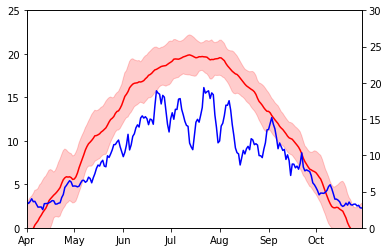

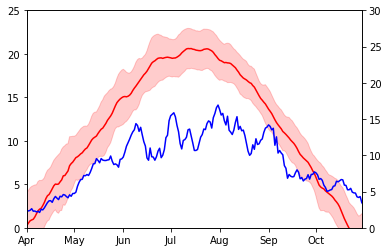

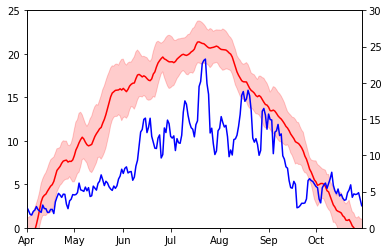

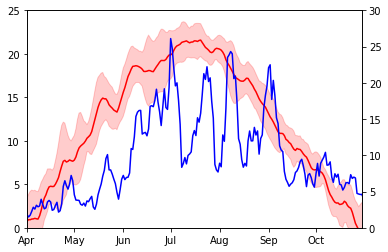

In [95]:
date_df = min_temp[['Month', 'Day']]
date_df['Year'] = [2000 for _ in range(len(date_df))]
x = pd.to_datetime(date_df)

for i in range(4):
    mean_temp = get_moving_avg(min_temp)[[year for year in a_classified[a_classified['Class 4']==i]['Year'] if year in min_temp.columns]]
    y = mean_temp.mean(axis=1)
    dy = mean_temp.std(axis=1)

    fig, ax = plt.subplots()

    ax.fill_between(x, y-dy, y+dy, color='red', alpha=0.2)
    ax.plot(x, y, c='red')

    mean_temp = get_moving_sum(min_prec)[[year for year in a_classified[a_classified['Class 4']==i]['Year'] if year in min_prec.columns]]
    y = mean_temp.mean(axis=1)
    ax2 = ax.twinx()
    ax2.plot(x, y, color='blue')
    ax2.set_ylim([0, 30])

    locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.set_xlim([date(2000, 4, 1), date(2000, 10, 30)])
    ax.set_ylim([0, 25])
    plt.show()

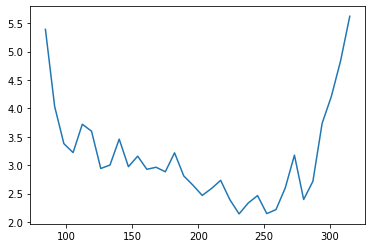

In [186]:
plt.plot(get_moving_avg(min_temp).std(axis=1)[12*7:46*7:7])

## ANOVA for Temperature

In [125]:
import statsmodels.api as sm
from statsmodels.formula.api import ols


In [134]:
temp_to_anova = []
for i in range(0,4):
    mean_temp = get_moving_avg(min_temp)[[year for year in a_classified[a_classified['Class 4']==i]['Year'] if year in min_temp.columns]]
    _temp_to_anova = mean_temp[7::7].T.reset_index().rename({'index':'Year'}, axis=1)
    _temp_to_anova['Class'] = [i+1] * len(_temp_to_anova)
    temp_to_anova += [_temp_to_anova]
temp_to_anova = pd.concat(temp_to_anova)

In [161]:
for j in range(12,46):
    lm = ols(f'Q({7*j}) ~ Class',data=temp_to_anova).fit()
    _p = sm.stats.anova_lm(lm)['PR(>F)']['Class']
    if _p <0.05:
        print(f"{j}: {_p:.2f}")

12: 0.02
16: 0.03
17: 0.02
18: 0.02
20: 0.00
23: 0.04
27: 0.04
28: 0.05
29: 0.01
30: 0.04


## ANOVA for Precipitation

In [162]:
prec_to_anova = []
for i in range(0,4):
    mean_prec = get_moving_sum(min_prec)[[year for year in a_classified[a_classified['Class 4']==i]['Year'] if year in min_prec.columns]]
    _prec_to_anova = mean_prec[7::7].T.reset_index().rename({'index':'Year'}, axis=1)
    _prec_to_anova['Class'] = [i+1] * len(_prec_to_anova)
    prec_to_anova += [_prec_to_anova]
prec_to_anova = pd.concat(prec_to_anova)

In [166]:
for j in range(12,46):
    lm = ols(f'Q({7*j}) ~ Class',data=prec_to_anova).fit()
    _p = sm.stats.anova_lm(lm)['PR(>F)']['Class']
    if _p <0.05:
        print(f"{j}: {_p:.2f}")

21: 0.01
40: 0.01


## ANOVA for tracheides

In [232]:
sm.stats.anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
Class_4,1.0,0.971944,0.971944,139.246785,9.831899e-25
Residual,200.0,1.396002,0.006980,NaN,NaN


In [200]:
names = []
sum_sq = []
mean_sq = []
Fs = []
PRs = []
for j in range(15):
    lm = ols(f'D{j+1} ~ Class_4',data=a_classified.rename({'Class 4':'Class_4'}, axis=1)).fit()
    table = sm.stats.anova_lm(lm)
    names += [f"D{j+1}"]
    sum_sq += [table['sum_sq']['Class_4']]
    sum_sq += [table['mean_sq']['Class_4']]
    sum_sq += [table['F']['Class_4']]
    sum_sq += [table['PR(>F)']['Class_4']]

for j in range(15):
    lm = ols(f'CWT{j+1} ~ Class_4',data=a_classified.rename({'Class 4':'Class_4'}, axis=1)).fit()
    table = sm.stats.anova_lm(lm)
    names += [f"CWT{j+1}"]
    sum_sq += [table['sum_sq']['Class_4']]
    sum_sq += [table['mean_sq']['Class_4']]
    sum_sq += [table['F']['Class_4']]
    sum_sq += [table['PR(>F)']['Class_4']]

trach_anova = pd.DataFrame({'Feature': names,
                            'sum_sq': sum_sq,
                            'mean_sq': mean_sq,
                            'F':Fs,
                            'PR(>F)':PRs
                            })

D1: 4.629524137934812e-37
D2: 7.22049077947563e-43
D3: 2.416705663667166e-45
D4: 2.522064443697978e-50
D5: 2.3959232704460954e-52
D6: 4.293044773530935e-56
D7: 1.3698489020757933e-60
D8: 4.295594568161526e-61
D9: 6.268206861519001e-58
D10: 1.2578307116925888e-50
D11: 3.787461799430051e-40
D12: 8.399569350243365e-33
D13: 5.01829685295361e-29
D14: 1.0618007209154603e-25
D15: 1.1122197547573111e-12
CWT1: 7.760111461091119e-09
CWT2: 4.796270701874205e-08
CWT3: 6.023221228363014e-06
CWT4: 0.0004445967840400431
CWT5: 0.0019865406853606365
CWT11: 0.00030032548743536854
CWT12: 1.1846586675419935e-09
CWT13: 4.016323960226452e-16
CWT14: 5.588153779123846e-21
CWT15: 9.831898668623199e-25


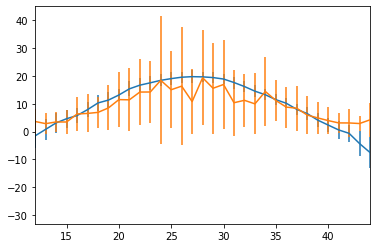

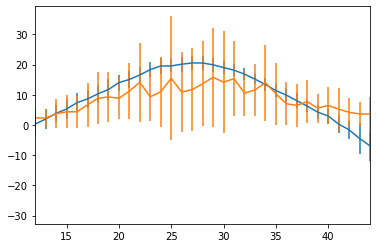

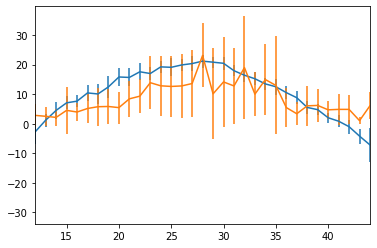

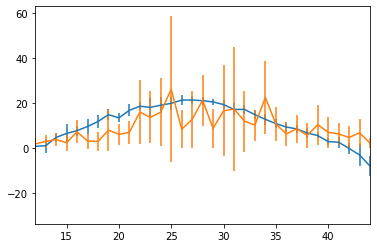

In [123]:
for i in range(0,4):
    mean_temp = get_moving_avg(min_temp)[[year for year in a_classified[a_classified['Class 4']==i]['Year'] if year in min_temp.columns]]
    y = mean_temp.mean(axis=1)
    plt.errorbar(range(0, len(y[7::7])), (y[7::7]),yerr=mean_temp.std(axis=1)[7::7])
    mean_temp = get_moving_sum(min_prec)[[year for year in a_classified[a_classified['Class 4']==i]['Year'] if year in min_prec.columns]]
    y = mean_temp.mean(axis=1)
    plt.errorbar(range(0, len(y[7::7])), (y[7::7]),yerr=mean_temp.std(axis=1)[7::7])
    plt.xlim([12, 46])
    plt.show()

In [104]:
def list_to_cumulative(lst):
    return [sum(lst[:i+1]) for i in range(len(lst))]

In [28]:
for i in range(4):
    fig, ax = plt.subplots(nrows=4, ncols=1, dpi=300, figsize=(6, 10))
    plt.subplots_adjust(bottom=0.03, top=0.95)
    ax2 = ax[0].twinx()
    ax4 = ax[1].twinx()
    ax[0].set_ylim([0, 25])
    ax2.set_ylim([0, 350])
    ax4.set_ylim([2, 16])
    ax[1].set_ylim([0.2, 3.2])
    ax[2].set_ylim([0.75, 1.2])
    ax[3].set_ylim([0.75, 1.2])
    ax[2].axhline(y=1, color='dimgray', linestyle='--')
    ax[3].axhline(y=1, color='dimgray', linestyle='--')
    ax[0].set_ylabel('Temperature (°C)')
    ax2.set_ylabel('Precipitation (mm)')
    ax[0].set_zorder(1)  # default zorder is 0 for ax1 and ax2
    ax[0].patch.set_visible(False)  # prevents ax1 from hiding ax2
    ax[1].set_ylabel('Hydrothermal Coefficient')
    ax4.set_ylabel('VPD')

    selected = a_classified[a_classified['Class 4']==i]
    temp_to_plot = monthly_temp.loc[monthly_temp['Year'].isin(list(selected['Year']))]
    print(i+1, len(temp_to_plot))
    ax[0].set_title(f'Class {i+1} ({len(temp_to_plot)} elements)')
    
    ax[0].plot(['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct'],
                temp_to_plot.mean(skipna=True)[4:11], color='red', label='Temperature', lw=5)
    ax[1].plot(['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct'],
                monthly_htc.loc[monthly_htc['Year'].isin(list(selected['Year']))].mean(skipna=True)[4:11], color='green', label='Hydrothermal Coefficient', lw=5)
    ax[1].plot([0], [100], color='gray', label='VPD', lw=4)
    ax4.plot(['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct'],
                monthly_vpd.loc[monthly_vpd['Year'].isin(list(selected['Year']))].mean(skipna=True)[5:12], color='gray', label='VPD', lw=4)
    ax2.bar(['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct'], 
            list_to_cumulative(monthly_prec.loc[monthly_prec['Year'].isin(list(selected['Year']))].mean(skipna=True)[4:11]), color='blue',  label='Precipitation')
            
    ax[2].plot(selected.mean()[1:16], label='Diameter deviation')
    ax[3].plot([f'C{j}' for j in range(1,16)], selected.mean()[16:31], label='CWT deviation')

    #ax[1].legend(frameon=False)
    ax[2].legend(frameon=False)
    ax[3].legend(frameon=False)
    plt.savefig(f'output/{i+1} Class (d&cwt)', dpi=300)
    plt.close(fig)

1 35
2 45
3 12
4 11


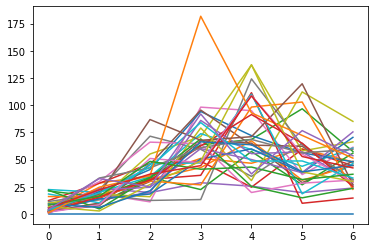

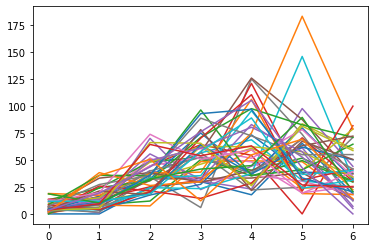

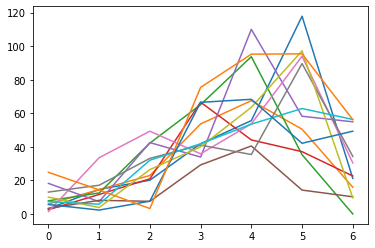

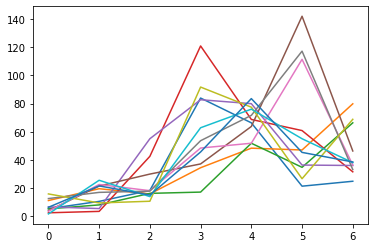

In [41]:
for c in range(4):
    for i, row in a_classified[a_classified['Class 4']==c].iterrows():
        if int(row[0]) in set(monthly_prec['Year']):
            plt.plot(monthly_prec[monthly_prec['Year']==int(row[0])].values[0][3:10])
    plt.show()

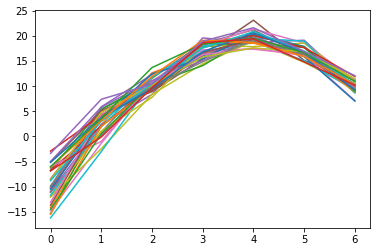

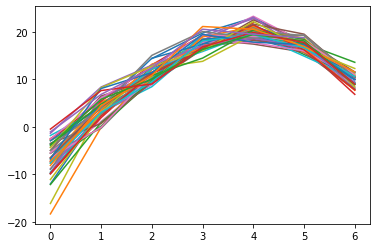

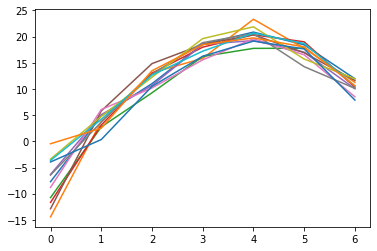

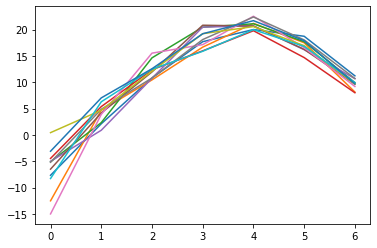

In [71]:
for c in range(4):
    for i, row in a_classified[a_classified['Class 4']==c].iterrows():
        if int(row[0]) in set(monthly_temp['Year']):
            plt.plot(monthly_temp[monthly_temp['Year']==int(row[0])].values[0][3:10])
    plt.show()